In [170]:
import numpy as np
import pydicom
import nibabel as nib
import os
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS, Birch, AffinityPropagation, MeanShift, DBSCAN, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz
from time import perf_counter
from itertools import permutations
import scipy
from scipy.stats import wilcoxon

In [109]:
# ds.NumberOfTimeSlices: 24
# ds.NumberOfSlices: 380
# ds.PixelSpacing for fitting images together

In [178]:
#function for cropping and reflecting the original image given by TotalSegmentator so that it corresponds with the pet images

def preprocessTotalSegImg(img_path):

    img=nib.load(img_path)
    img=img.get_fdata()
    img1=np.zeros((220,220,380))
    for i in range(380):
        img_i=cv2.resize(img[70:442,70:442,379-i],(220,220))
        for j in range(220):
            img1[:,j,i]=img_i[j,:]
    img1=cv2.flip(img1,0)
    img1=np.round(img1,1)
    return(img1)

#function for finding time and location information about the order of dcm image slices

def infoFromDcm(pathToDcmFolder):

    #for each dcm image in the folder, collect the information what is its acquisition time and slice location
    times=[]
    locs=[]
    for i in range(len(os.listdir(pathToDcmFolder))):
        file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
        ds=pydicom.dcmread(file)
        times.append(ds.AcquisitionTime)
        locs.append(ds.SliceLocation)
    #create vectors for all the possible unique values of acquistion time and location
    uniTimes=np.sort(np.unique(np.array(times)))
    uniLocs=np.sort(np.unique(np.array(locs)))
    #return the vectors
    return([times,locs,uniTimes,uniLocs])

#function for choosing random locations inside the jth target class of the image given by TotalSegmentator

def chooseCurveLocs(img,j,numberOfCurves):
    
    #create another image matrix where the values within the greatest connected component of the target are 1 and the others are 0
    img1=np.array(img==j,dtype=int)
    structure=np.ones((3,3,3),dtype=int)
    labeled, ncomponents = label(img1,structure)
    u1=[]
    for u in range(1,ncomponents+1):
        img0=np.array(labeled==u,dtype=int)
        u1.append(np.sum(img0))
    u=np.argmax(u1)+1
    img1=np.array(labeled==u,dtype=int)
    #find the smallest rectangle containing the greatest connected component of the target by studying the maximums
    k5=0
    while(np.max(img1[:,:,k5])==0):
        k5+=1
    k6=k5
    while(np.max(img1[:,:,k6])>0):
        k6+=1
    k3=0
    while(np.max(img1[:,k3,k5:k6])==0):
        k3+=1
    k4=k3
    while(np.max(img1[:,k4,k5:k6])>0):
        k4+=1
    k1=0
    while(np.max(img1[k1,k3:k4,k5:k6])==0):
        k1+=1
    k2=k1
    while(np.max(img1[k2,k3:k4,k5:k6])>0):
        k2+=1
    #choose random locations within the found rectangle
    points=np.zeros((numberOfCurves,3))
    uList=[]
    for i in range(numberOfCurves):
        x=int(np.random.choice(range(k1,k2),size=1))
        y=int(np.random.choice(range(k3,k4),size=1))
        z=int(np.random.choice(range(k5,k6),size=1))
        u='{}.{}.{}'.format(x,y,z)
        #ensure that the chosen locations are within greatest connected component of the target and unique
        while(img1[x,y,z]==0 or u in uList):
            x=int(np.random.choice(range(k1,k2),size=1))
            y=int(np.random.choice(range(k3,k4),size=1))
            z=int(np.random.choice(range(k5,k6),size=1))
            u='{}.{}.{}'.format(x,y,z)
        points[i,:]=np.array([x,y,z])
        uList.append(u)
    #return the chosen locations as an numberOfCurves*3-array
    return(points)

#function for choosing a corner point of a random cube inside the jth target class of the image given by TotalSegmentator

def chooseCornerPoint(img,j,sideLength):
    
    #create another image matrix where the values within the greatest connected component of the target are 1 and the others are 0
    img1=np.array(img==j,dtype=int)
    structure=np.ones((3,3,3),dtype=int)
    labeled, ncomponents = label(img1,structure)
    u1=[]
    for u in range(1,ncomponents+1):
        img0=np.array(labeled==u,dtype=int)
        u1.append(np.sum(img0))
    u=np.argmax(u1)+1
    img1=np.array(labeled==u,dtype=int)
    #find the smallest rectangle containing the greatest connected component of the target by studying the maximums
    k5=0
    while(np.max(img1[:,:,k5])==0):
        k5+=1
    k6=k5
    while(np.max(img1[:,:,k6])>0):
        k6+=1
    k3=0
    while(np.max(img1[:,k3,k5:k6])==0):
        k3+=1
    k4=k3
    while(np.max(img1[:,k4,k5:k6])>0):
        k4+=1
    k1=0
    while(np.max(img1[k1,k3:k4,k5:k6])==0):
        k1+=1
    k2=k1
    while(np.max(img1[k2,k3:k4,k5:k6])>0):
        k2+=1
    #choose a random point for the corner point of a random cube within the found rectangle
    x=int(np.random.choice(range(k1,k2-sideLength),size=1))
    y=int(np.random.choice(range(k3,k4-sideLength),size=1))
    z=int(np.random.choice(range(k5,k6-sideLength),size=1))
    #ensure that the cube is within greatest connected component of the target
    while(np.min(img1[x:x+sideLength,y:y+sideLength,z:z+sideLength])==0):
        x=int(np.random.choice(range(k1,k2-sideLength),size=1))
        y=int(np.random.choice(range(k3,k4-sideLength),size=1))
        z=int(np.random.choice(range(k5,k6-sideLength),size=1))
    #return the chosen point
    return(np.array([x,y,z]))

#function for choosing the time activity curves from list of their locations

def chooseTACs(points,pathToDcmFolder,times,locs,uniTimes,uniLocs):

    arrayForTACs=np.zeros((points.shape[0],len(uniTimes)))
    for i in range(len(os.listdir(pathToDcmFolder))):
        #check if points contain a slice in the same location as the ith dcm image
        if np.argmax(np.array(locs[i]==uniLocs,dtype=int)) in points[:,2]:
            file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
            ds=pydicom.dcmread(file)
            #l is the index of the acquisition time corresponding to the ith dcm image
            l=np.argmax(np.array(times[i]==uniTimes,dtype=int))
            #j is the index of the slice in locList[k] with same location as the ith dcm image
            for j in np.nonzero(np.array(np.argmax(np.array(locs[i]==uniLocs,dtype=int))==points[:,2],dtype=int))[0]:
                arrayForTACs[j,l]=ds.pixel_array[int(points[j,0]),int(points[j,1])]*ds[0x0028, 0x1053].value+ds[0x0028, 0x1052].value
    return(arrayForTACs)

#function for choosing time activity curves in the cube

def chooseTACsInCube(point,sideLength,pathToDcmFolder,times,locs,uniTimes,uniLocs):

    arrayOfTACs=np.zeros((sideLength,sideLength,sideLength,len(uniTimes)))
    for i in range(len(os.listdir(pathToDcmFolder))):
        #check if locList[k] contains a slice in the same location as the ith dcm image
            if np.argmax(np.array(locs[i]==uniLocs,dtype=int)) in range(point[2],point[2]+sideLength):
                file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
                ds=pydicom.dcmread(file)
                #l is the index of the acquisition time corresponding to the ith dcm image
                l=np.argmax(np.array(times[i]==uniTimes,dtype=int))
                #j is the index of the slice in the cube with same location as the ith dcm image
                for j in range(sideLength):
                    if np.argmax(np.array(locs[i]==uniLocs,dtype=int))==point[2]+j:
                        arrayOfTACs[:,:,j,l]=ds.pixel_array[point[0]:point[0]+sideLength,point[1]:point[1]+sideLength]*ds[0x0028, 0x1053].value+ds[0x0028, 0x1052].value
    return(arrayOfTACs)

#function for running the clustering algorithms

def clusterAlg(curves,clusterNumber):

    labelList=[]
    clusteringMethods=[]
    processingTimes=[]
    #PCA+Kmeans
    startTime=perf_counter()
    PCA_clustering=PCA(n_components=clusterNumber).fit_transform(curves)
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    startTime=perf_counter()
    PCA_labels=KMeans(n_clusters=clusterNumber).fit_predict(PCA_clustering)
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(PCA_labels)
    clusteringMethods.append('PCA+Kmeans')
    startTime=perf_counter()
    MiniPCA_labels=MiniBatchKMeans(n_clusters=clusterNumber).fit_predict(PCA_clustering)
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(MiniPCA_labels)
    clusteringMethods.append('PCA+MiniBatchKmeans')
    #ICA+Kmeans
    startTime=perf_counter()
    ICA_clustering=FastICA(n_components=clusterNumber).fit_transform(curves)
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    startTime=perf_counter()
    ICA_labels=KMeans(n_clusters=clusterNumber).fit_predict(ICA_clustering)
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(ICA_labels)
    clusteringMethods.append('ICA+Kmeans')
    startTime=perf_counter()
    MiniICA_labels=MiniBatchKMeans(n_clusters=clusterNumber).fit_predict(ICA_clustering)
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(MiniICA_labels)
    clusteringMethods.append('ICA+MiniBatchKmeans')
    #gaussian mixture model
    startTime=perf_counter()
    GMM_model=GaussianMixture(n_components=clusterNumber).fit(curves)
    GMM_labels=GMM_model.predict(curves)
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(GMM_labels)
    clusteringMethods.append('GMM')
    #Hierarchical clustering
    startTime=perf_counter()
    Agg_clustering=AgglomerativeClustering(n_clusters=clusterNumber).fit(curves)
    Agg_labels=Agg_clustering.labels_
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(Agg_labels)
    clusteringMethods.append('Agglomerative')
    #Spectral clustering
    startTime=perf_counter()
    Spectral_clustering=SpectralClustering(n_clusters=clusterNumber).fit(curves)
    Spectral_labels=Spectral_clustering.labels_
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(Spectral_labels)
    clusteringMethods.append('Spectral')
    #OPTICS clustering
    startTime=perf_counter()
    Optics_clustering=OPTICS().fit(curves)
    Optics_labels=Optics_clustering.labels_+1
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(Optics_labels)
    clusteringMethods.append('Optics')
    #Birch clustering
    startTime=perf_counter()
    Birch_clustering=Birch(n_clusters=clusterNumber).fit(curves)
    Birch_labels=Birch_clustering.labels_
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(Birch_labels)
    clusteringMethods.append('Birch')
    #AffinityPropagation clustering
    startTime=perf_counter()
    Aff_clustering=AffinityPropagation().fit(curves)
    Aff_labels=Aff_clustering.labels_
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(Aff_labels)
    clusteringMethods.append('AffinityPropagation')
    #Mean shift
    startTime=perf_counter()
    MS_clustering=MeanShift().fit(curves)
    MS_labels=MS_clustering.labels_
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(MS_labels)
    clusteringMethods.append('MeanShift')
    #DBSCAN
    startTime=perf_counter()
    DBSCAN_clustering=DBSCAN().fit(curves)
    DBSCAN_labels=DBSCAN_clustering.labels_+1
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(DBSCAN_labels)
    clusteringMethods.append('DBSCAN')
    #fuzzy c-means
    startTime=perf_counter()
    u=fuzz.cluster.cmeans(np.transpose(curves),clusterNumber,3,0.005,1000)
    fcp_labels=np.argmax(u[1],axis=0)
    endTime=perf_counter()
    processingTimes.append(endTime-startTime)
    labelList.append(fcp_labels)
    clusteringMethods.append('Fuzzy c-means')
    return(labelList,clusteringMethods,processingTimes)

#function for evaluating of predicted labels

def evaluatedPredLabels(predictedLabels,curveLabels,clusterNumber):

    numberOfCurves=len(predictedLabels)
    #if there are too many clusters, combine the smallest of them to one cluster
    numberOfPredClusters=len(np.unique(predictedLabels))
    if numberOfPredClusters>clusterNumber:
        clusterSizes=[]
        for i in range(numberOfPredClusters):
            clusterSizes.append(np.sum(predictedLabels==i))
        newPredictedLabels=np.zeros((numberOfCurves))
        for j in range(1,clusterNumber):
            for i in range(numberOfCurves):
                if predictedLabels[i]==np.argmax(clusterSizes):
                    newPredictedLabels[i]=int(j)
            clusterSizes[np.argmax(clusterSizes)]=0
        predictedLabels=newPredictedLabels.astype('int64')
    #create an array that shows how different curves are divided in clusters
    divArray=np.zeros((clusterNumber,clusterNumber))
    for i in range(numberOfCurves):
        divArray[predictedLabels[i],curveLabels[i]]+=1
    #order the array to maximize diagonal sums
    diagSums=[]
    for order in list(permutations(range(clusterNumber))):
        diagSums.append(np.sum(np.diag(divArray[order,:])))
    order=list(permutations(range(clusterNumber)))[np.argmax(diagSums)]
    divArray1=divArray[order,:]
    metricValues=[]
    metricValues.append(np.sum(np.diag(divArray1))/np.sum(divArray1))
    for i in range(clusterNumber):
        if np.sum(divArray1[:,i])>0:
            metricValues.append(divArray1[i,i]/np.sum(divArray1[:,i]))
        else:
            metricValues.append(0)
        if np.sum(divArray1[i,:])>0:
            metricValues.append(divArray1[i,i]/np.sum(divArray1[i,:]))
        else:
            metricValues.append(0)
    return(metricValues)

#f-test of equal variance

def f_test(x,y):

    x=np.array(x)
    y=np.array(y)
    f=np.var(x,ddof=1)/np.var(y,ddof=1)
    dfn=x.size-1
    dfd=y.size-1
    p=2*min(1-scipy.stats.f.cdf(f,dfn,dfd),scipy.stats.f.cdf(f,dfn,dfd))
    return(p)

In [5]:
studyCode='koveri0030'
files=os.listdir('D:/koveri/Data/{}'.format(studyCode))
for i in files:
    if 'segments.nii' in i:
        img_path='D:/koveri/Data/{}/{}'.format(studyCode,i)
    if 'Rest' in i or 'rest' in i:
        pathToDcmFolder='D:/koveri/Data/{}/{}/{}'.format(studyCode,i,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,i))[0])
img=preprocessTotalSegImg(img_path)
times,locs,uniTimes,uniLocs=infoFromDcm(pathToDcmFolder)

#indices: 6. brain, 26. right heart ventricle, 39. right kidney, 42. lower right lung lobe, 80. urinary bladder
indices=[6,26,39,42,80]
organs=['brain','heart','kidney','lung','bladder'] 
clusterNumber=len(indices)
numberOfCurves=1000
#sideLength=10
#numberOfCurves=sideLength**3
TACList=[]
for j in indices:
    points=chooseCurveLocs(img,j,numberOfCurves)
    arrayOfTACs=chooseTACs(points,pathToDcmFolder,times,locs,uniTimes,uniLocs)
    #point=chooseCornerPoint(img,j,sideLength)
    #arrayOfTACs=chooseTACsInCube(point,sideLength,pathToDcmFolder,times,locs,uniTimes,uniLocs)
    TACList.append(arrayOfTACs)
    print(j)

curves=[]
curveLabels=np.array(list(range(clusterNumber))*numberOfCurves)
for i in range(numberOfCurves):
    for l in range(clusterNumber):
        curves.append(TACList[l][i,:])
#for i in range(sideLength):
#    for j in range(sideLength):
#        for k in range(sideLength):
#            for l in range(clusterNumber):
#                curves.append(TACList[l][i,j,k,:])
curves=np.array(curves)

labelList,clusteringMethods,processingTimes=clusterAlg(curves,clusterNumber)

eval=np.zeros((13,11))
for i in range(13):
    eval[i,:]=evaluatedPredLabels(labelList[i],curveLabels,clusterNumber)

np.savetxt('{}_labels.txt'.format(studyCode),np.array(labelList))
np.savetxt('{}_times.txt'.format(studyCode),np.array(processingTimes))
np.savetxt('{}_eval.txt'.format(studyCode),eval)

6
26
39
42
80


c:\Users\Oona\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Oona\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


In [26]:
i=12
files=os.listdir('C:/Users/Oona/Documents/Tpc/clus')
eval=[]
for j in range(len(files)):
    if 'eval.txt' in files[j]:
        eval.append(np.loadtxt(files[j])[i])
eval=np.array(eval)
v=np.median(eval,axis=0)
v=100*v
print(clusteringMethods[i])
print(round(v[0],1),'&',round(v[1],1),'&',round(v[2],1),'&',round(v[3],1),'&',round(v[4],1),'&',round(v[5],1),'&',
      round(v[6],1),'&',round(v[7],1),'&',round(v[8],1),'&',round(v[9],1),'&',round(v[10],1))

Fuzzy c-means
83.1 & 89.7 & 74.9 & 64.6 & 99.9 & 78.0 & 93.7 & 86.1 & 76.1 & 100.0 & 84.8


In [140]:
i=0
i1=1
files=os.listdir('C:/Users/Oona/Documents/Tpc/clus')
eval=[]
eval1=[]
for j in range(len(files)):
    if 'eval.txt' in files[j]:
        eval.append(np.loadtxt(files[j])[i,0])
        eval1.append(np.loadtxt(files[j])[i1,0])
eval=np.array(eval)
eval1=np.array(eval1)
print(clusteringMethods[i])
print(clusteringMethods[i1])
print(wilcoxon(x=eval,y=eval1))

PCA+Kmeans
PCA+MiniBatchKmeans
WilcoxonResult(statistic=205.0, pvalue=0.5716457836721114)


In [166]:
i=12
files=os.listdir('C:/Users/Oona/Documents/Tpc/clus')
eval=[]
for j in range(len(files)):
    if 'eval.txt' in files[j]:
        eval.append(np.loadtxt(files[j])[i,0])
eval=np.array(eval)
print(clusteringMethods[i])
print(round(100*np.std(eval),1))

Fuzzy c-means
10.8


In [190]:
i=12
i1=4
files=os.listdir('C:/Users/Oona/Documents/Tpc/clus')
eval=[]
eval1=[]
for j in range(len(files)):
    if 'eval.txt' in files[j]:
        eval.append(np.loadtxt(files[j])[i,0])
        eval1.append(np.loadtxt(files[j])[i1,0])
eval=np.array(eval)
eval1=np.array(eval1)
print(clusteringMethods[i])
print(clusteringMethods[i1])
print(f_test(x=eval,y=eval1))

Fuzzy c-means
GMM
0.240896683672642


In [151]:
files=os.listdir('C:/Users/Oona/Documents/Tpc/clus')
times=[]
for j in range(len(files)):
    if 'times.txt' in files[j]:
        times.append(np.loadtxt(files[j]))
times=np.array(times)
v=np.mean(times,axis=0)
for i in range(2,len(v)):
    print(clusteringMethods[i-2],round(v[i],3))

PCA+Kmeans 0.063
PCA+MiniBatchKmeans 0.06
ICA+Kmeans 0.182
ICA+MiniBatchKmeans 0.034
GMM 0.597
Agglomerative 1.45
Spectral 5.911
Optics 8.596
Birch 2.028
AffinityPropagation 182.409
MeanShift 43.809
DBSCAN 0.466
Fuzzy c-means 0.18


In [196]:
len(np.unique(np.loadtxt('koveri0001_labels.txt')[0]))

5

In [209]:
i=6
files=os.listdir('C:/Users/Oona/Documents/Tpc/clus')
cNumbers=[]
for j in range(len(files)):
    if 'labels.txt' in files[j]:
        cNumbers.append(len(np.unique(np.loadtxt(files[j])[i])))
print(clusteringMethods[i])
print(cNumbers)

Spectral
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [210]:
print(np.min(cNumbers))
print(np.max(cNumbers))
print(np.mean(cNumbers))

5
5
5.0


In [227]:
i=6
files=os.listdir('C:/Users/Oona/Documents/Tpc/clus')
v=np.zeros((30,5))
l=0
for j in range(len(files)):
    if 'labels.txt' in files[j]:
        for k in range(5):
            v[l,k]=np.sum(np.loadtxt(files[j])[i]==k)
        l+=1
print(clusteringMethods[i])

Spectral


In [228]:
minVs=[]
for j in range(30):
    minVs.append(np.min(v[j,:]))
print(np.min(minVs))

maxVs=[]
for j in range(30):
    maxVs.append(np.max(v[j,:]))
print(np.max(maxVs))

1.0
4993.0


brain


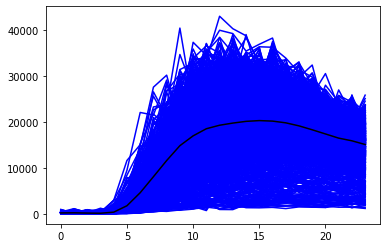

heart


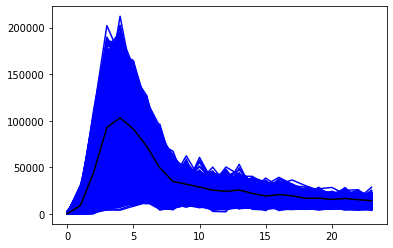

kidney


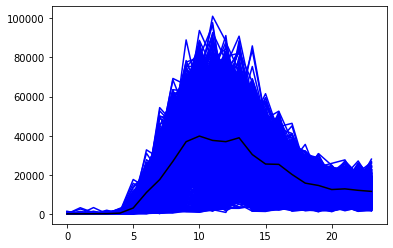

lung


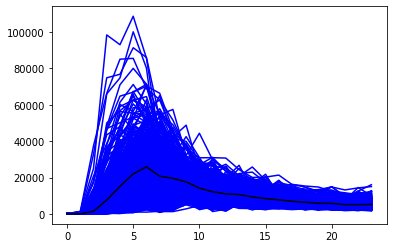

bladder


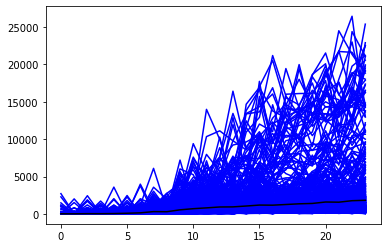

In [35]:
for l in range(clusterNumber):
    print(organs[l])
    for i in range(numberOfCurves):
        plt.plot(range(len(uniTimes)),curves[clusterNumber*i+l],color='blue')
    plt.plot(range(len(uniTimes)),curves[np.array(np.array(range(numberOfCurves))*clusterNumber+l)].mean(axis=0),color='black')
    plt.show()

In [19]:
for i in range(len(labelList)):
    print(clusteringMethods[i],round(evaluatedPredLabels(labelList[i],curveLabels,clusterNumber)[0],3))

PCA+Kmeans 0.726
PCA+MiniBatchKmeans 0.542
ICA+Kmeans 0.727
ICA+MiniBatchKmeans 0.738
GMM 0.908
Agglomerative 0.772
Spectral 0.204
Optics 0.21
Birch 0.772
AffinityPropagation 0.2
MeanShift 0.36
DBSCAN 0.2
Fuzzy c-means 0.752


In [20]:
print(processingTimes)

[0.07757330000004004, 0.17883979999987787, 0.26150849999976344, 0.04910740000013902, 0.21333179999965068, 0.033140499999717576, 0.43469080000022586, 2.1087557000000743, 7.444442800000161, 10.18410380000023, 2.4457072000000153, 225.64873780000016, 49.32745429999977, 0.48742719999972905, 0.202138599999671]


In [21]:
i=0
print(clusteringMethods[i])
predictedLabels=labelList[i]
metricValues=evaluatedPredLabels(predictedLabels,curveLabels,clusterNumber)
print('Accuracy :',round(metricValues[0],3))
for i in range(clusterNumber):
    print('Sensitivity of',organs[i],':',round(metricValues[2*i+1],3))
    print('Specificity of',organs[i],':',round(metricValues[2*i+2],3))

PCA+Kmeans
Accuracy : 0.726
Sensitivity of brain : 0.88
Specificity of brain : 0.584
Sensitivity of heart : 0.585
Specificity of heart : 0.998
Sensitivity of kidney : 0.54
Specificity of kidney : 0.978
Sensitivity of lung : 0.626
Specificity of lung : 0.634
Sensitivity of bladder : 1.0
Specificity of bladder : 0.732


In [ ]:
times=[]
locs=[]
for i in range(len(os.listdir(pathToDcmFolder))):
    file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
    ds=pydicom.dcmread(file)
    times.append(ds.AcquisitionTime)
    locs.append(ds.SliceLocation)
uniTimes=np.sort(np.unique(np.array(times)))
uniLocs=np.sort(np.unique(np.array(locs)))
img3d=np.zeros((220,220,380))
for i in range(len(os.listdir(pathToDcmFolder)))):
    if times[i]==uniTimes[18]:
        file='{}/{}'.format(pathToDcmFolder),os.listdir(pathToDcmFolder))[i])
        ds=pydicom.dcmread(file)
        for j in range(len(uniLocs)):
            if uniLocs[j]==locs[i]:
                img3d[:,:,j]=ds.pixel_array*ds[0x0028, 0x1053].value+ds[0x0028, 0x1052].value

In [ ]:
ctfilepath='D:/koveri/Data/koveri0001/CT_3.0__Br36__5'
ctlocs=[]
for i in range(len(os.listdir(ctfilepath))):
    file='{}/{}'.format(ctfilepath,os.listdir(ctfilepath)[i])
    if file[-4:]=='.dcm':
        ds=pydicom.dcmread(file)
        ctlocs.append(ds.SliceLocation)
ctUniLocs=np.sort(np.unique(np.array(ctlocs)))

ctImg=np.zeros((512,512,380))
for i in range(len(os.listdir(ctfilepath))):
    file='{}/{}'.format(ctfilepath,os.listdir(ctfilepath)[i])
    if file[-4:]=='.dcm':
        ds=pydicom.dcmread(file)
        for j in range(len(ctUniLocs)):
            if ctUniLocs[j]==ctlocs[i]:
                ctImg[:,:,j]=ds.pixel_array
print(ds.ImagePositionPatient)
print(ds.PixelSpacing)
print(256-110*1.65/0.9765625)
print(256+110*1.65/0.9765625)
plt.imshow(cv2.resize(ctImg[70:442,256,:],(380,220)),cmap='gray')

In [10]:
curves=[]
curveLabels=np.array([0,1,2]*15)
for i in range(15):
    curves.append(np.random.normal(0,1,10))
    curves.append(np.random.normal(3,1,10))
    curves.append(np.random.normal(0,5,10))
curves=np.array(curves)

In [70]:
from sklearn.decomposition import FastICA
#ICA+Kmeans
ICA_clustering=FastICA(n_components=clusterNumber).fit_transform(curves)
ICA_labels=KMeans(n_clusters=clusterNumber).fit_predict(ICA_clustering)
print(ICA_labels)

[0 1 0 0 1 1 0 1 0 0 1 2 0 1 0 0 1 0 0 1 2 0 1 1 0 1 2 0 1 0 0 1 0 0 1 2 0
 1 0 0 1 0 0 1 0]
